In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv


# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# NLP libraries

import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

2025-11-29 04:43:48.413646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764391428.925727      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764391429.059556      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Load dataset

In [6]:
df = pd.read_csv("/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv")

In [8]:
print(df.head())
print("-------")
print(df['status'].value_counts())

   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety
-------
status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


# Clean text

In [9]:
import re

def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub("[^a-zA-Z ]", "", text)
        tokens = text.split()
        return " ".join(tokens)
    return ""

df["clean_statement"] = df["statement"].apply(clean_text)

print(df.head())
print(df.columns)


   Unnamed: 0                                          statement   status  \
0           0                                         oh my gosh  Anxiety   
1           1  trouble sleeping, confused mind, restless hear...  Anxiety   
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3           3  I've shifted my focus to something else but I'...  Anxiety   
4           4  I'm restless and restless, it's been a month n...  Anxiety   

                                     clean_statement  
0                                         oh my gosh  
1  trouble sleeping confused mind restless heart ...  
2  all wrong back off dear forward doubt stay in ...  
3  ive shifted my focus to something else but im ...  
4  im restless and restless its been a month now ...  
Index(['Unnamed: 0', 'statement', 'status', 'clean_statement'], dtype='object')


In [10]:
print(df.columns)


Index(['Unnamed: 0', 'statement', 'status', 'clean_statement'], dtype='object')


# Split data

In [11]:

le = LabelEncoder()
df['label'] = le.fit_transform(df['status'])

# Train-test split

X_train, X_test, y_train, y_test = train_test_split(df['clean_statement'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])


# Train Linear SVM

In [12]:
# Vectorization using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


Accuracy: 0.7690640022622302
Classification Report:
                       precision    recall  f1-score   support

             Anxiety       0.82      0.79      0.80       778
             Bipolar       0.83      0.75      0.79       575
          Depression       0.73      0.73      0.73      3081
              Normal       0.85      0.95      0.89      3270
Personality disorder       0.79      0.52      0.63       240
              Stress       0.66      0.47      0.55       534
            Suicidal       0.68      0.65      0.66      2131

            accuracy                           0.77     10609
           macro avg       0.76      0.69      0.72     10609
        weighted avg       0.76      0.77      0.76     10609



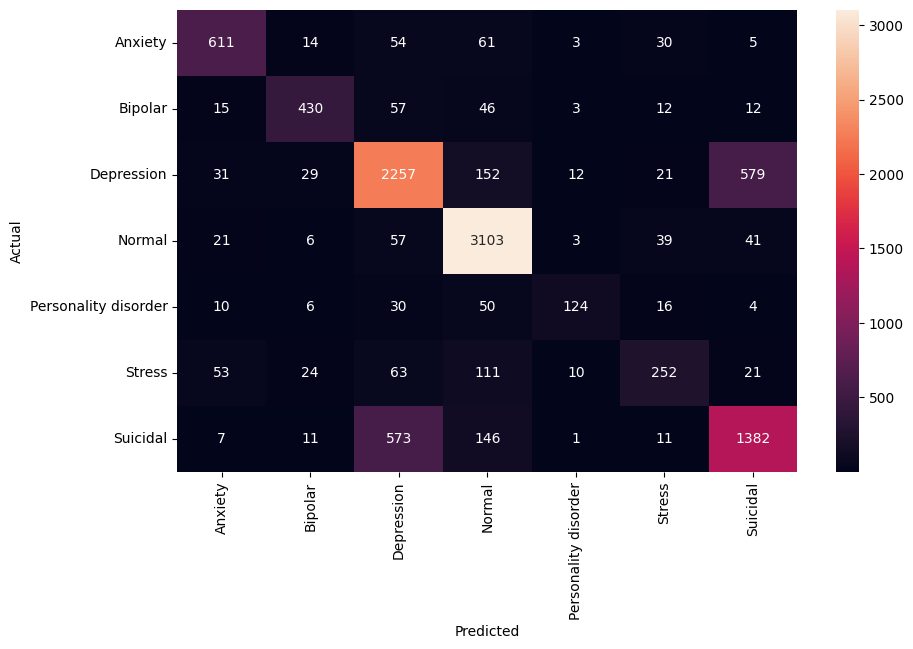

In [14]:
from sklearn.svm import LinearSVC

svm_clf = LinearSVC()
svm_clf.fit(X_train_tfidf, y_train)
y_pred = svm_clf.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


# Part B: Bidirectional GRU model

In [27]:
from tensorflow.keras.layers import Bidirectional, GRU

# Tokenizer and padding remain same
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# --- Bidirectional GRU model ---
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    Bidirectional(GRU(128, dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train_cat.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_test_pad, y_test_cat),
    epochs=5,
    batch_size=64
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


664/664 ━━━━━━━━━━━━━━━━━━━━ 198s 288ms/step - accuracy: 0.5443 - loss: 1.1915 - val_accuracy: 0.6994 - val_loss: 0.7573
Epoch 2/5
664/664 ━━━━━━━━━━━━━━━━━━━━ 191s 287ms/step - accuracy: 0.7197 - loss: 0.7007 - val_accuracy: 0.7555 - val_loss: 0.6181
Epoch 3/5
664/664 ━━━━━━━━━━━━━━━━━━━━ 191s 287ms/step - accuracy: 0.7826 - loss: 0.5371 - val_accuracy: 0.7665 - val_loss: 0.5776
Epoch 4/5
664/664 ━━━━━━━━━━━━━━━━━━━━ 191s 287ms/step - accuracy: 0.8245 - loss: 0.4474 - val_accuracy: 0.7736 - val_loss: 0.5768
Epoch 5/5
664/664 ━━━━━━━━━━━━━━━━━━━━ 193s 291ms/step - accuracy: 0.8534 - loss: 0.3736 - val_accuracy: 0.7676 - val_loss: 0.6117


In [ ]:
# --- Chatbot setup ---

suicidal_words = [
    "suicide", "kill", "kill myself", "i want to die", "end my life",
    "die", "i want to end it", "i dont want to live",
    "life is pointless", "i cant go on", "ending it", "i should die",
    "i want to disappear", "no reason to live"
]

selfharm_words = [
    "self harm", "cut", "cut myself", "hurt myself", "burn myself",
    "i want to hurt myself", "i deserve pain", "i feel like cutting",
    "i want to bleed", "i want to hurt my body", "scratch myself"
]

depression_words = [
    "depressed", "depression", "empty", "numb", "tired of life",
    "no energy", "i feel nothing", "hopeless", "nothing matters",
    "sad all the time", "lost interest", "worthless", "i cant focus",
    "low mood", "i feel broken", "i feel stuck", "down", "crying"
]


all_keywords = suicidal_words + selfharm_words + depression_words
pattern = "|".join([re.escape(k) for k in all_keywords])

# --- Risk assessment function ---
def assess_risk_gru(text):
    # Tokenize and pad
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    
    # GRU model prediction
    proba = model.predict(pad, verbose=0)[0]
    pred_class = np.argmax(proba)
    class_name = le.inverse_transform([pred_class])[0]
    
    # Keyword risk
    keyword_risk = 1.0 if re.search(pattern, text.lower()) else 0.0
    
    # Model risk: assign weights
    if class_name.lower() == "suicidal":
        model_risk = 1.0
    elif class_name.lower() == "depression":
        model_risk = 0.5
    else:
        model_risk = 0.0
    
    # Sentiment risk (optional)
    vader_risk = max(0, -sia.polarity_scores(text)["compound"])
    
    # Combined risk score
    risk_score = 0.4*keyword_risk + 0.4*model_risk + 0.2*vader_risk
    if risk_score >= 0.7:
        level = "high"
    elif risk_score >= 0.35:
        level = "medium"
    else:
        level = "low"
    
    return level, risk_score, class_name

# --- Chatbot function ---
def chatbot_gru():
    print("Mental Health Chatbot (type 'quit' to exit)")
    while True:
        user_input = input("You: ")
        if user_input.lower() == "quit":
            print("Bot: Take care! Seek professional help if needed.")
            break
        level, score, label = assess_risk_gru(user_input)
        if level == "high":
            response = "I hear you're in serious distress. Please contact a mental health professional immediately."
        elif level == "medium":
            response = "It sounds like you're struggling. Talking to someone you trust may help."
        else:
            response = "Thanks for sharing. How are you feeling today?"
        print(f"Bot ({level} risk, score={score:.2f}, predicted: {label}): {response}")

# --- Run the chatbot ---
chatbot_gru()


Mental Health Chatbot (type 'quit' to exit)


You:  "I just got a promotion at work and I feel so excited and grateful today!"


Bot (low risk, score=0.00, predicted: Normal): Thanks for sharing. How are you feeling today?


You:  "I feel worthless and hopeless; nothing seems to matter anymore."


Bot (high risk, score=0.74, predicted: Depression): I hear you're in serious distress. Please contact a mental health professional immediately.


----